In [11]:
import torch
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import optim
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [17]:
x_data = pd.read_csv("../python-docker/swedbank/x_Swedbank_A_30_p_macd.csv", sep=";", usecols = [i for i in range(31)])

In [18]:
y_data = pd.read_csv("../python-docker/swedbank/y_Swedbank_A_30.csv", sep=";")

In [19]:
x_data.head() 

,Swedbank_A-price-0,Swedbank_A-price-1,Swedbank_A-price-2,Swedbank_A-price-3,Swedbank_A-price-4,Swedbank_A-price-5,Swedbank_A-price-6,Swedbank_A-price-7,Swedbank_A-price-8,Swedbank_A-price-9,...,Swedbank_A-price-21,Swedbank_A-price-22,Swedbank_A-price-23,Swedbank_A-price-24,Swedbank_A-price-25,Swedbank_A-price-26,Swedbank_A-price-27,Swedbank_A-price-28,Swedbank_A-price-29,Swedbank_Amacd
0,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,...,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,1.421085e-13
1,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,...,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.20,1.421085e-13
2,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,...,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.20,1.421085e-13
3,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,...,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.20,1.421085e-13
4,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,...,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.14,145.20,1.421085e-13


In [20]:
y_data.head()

,15s,15sa,15ud,30s,30sa,30ud,45s,45sa,45ud,60s,...,180s,180sa,180ud,300s,300sa,300ud,600s,600sa,600ud,ts
0,145.14,145.0,0,145.14,145.070000,0,145.24,145.24,1,145.32,...,145.16,145.168,1,145.34,145.263,1,145.26,145.238333,1,1604390404
1,145.14,145.0,-1,145.00,145.046667,-1,145.24,145.24,1,145.32,...,145.16,145.168,-1,145.34,145.263,1,145.26,145.238333,1,1604390405
2,145.14,145.0,-1,145.00,145.046667,-1,145.24,145.24,1,145.32,...,145.16,145.168,-1,145.34,145.263,1,145.26,145.238333,1,1604390406
3,145.14,145.0,-1,145.00,145.046667,-1,145.24,145.24,1,145.32,...,145.16,145.168,-1,145.34,145.263,1,145.26,145.238333,1,1604390407
4,145.14,145.0,-1,145.00,145.046667,-1,145.24,145.24,1,145.32,...,145.16,145.168,-1,145.34,145.263,1,145.26,145.238333,1,1604390408


In [21]:
x_data.shape

(1809209, 31)

In [22]:
y_data = y_data["15s"] #300s - 5min exakt price
y_data.shape

(1809209,)

In [23]:
def splitData(xs, ys, trainRatio):
    t = round(len(xs)*trainRatio)
    
    train_data_x = torch.tensor(xs[:t].values, dtype=torch.float32)
    train_data_y = torch.tensor(ys[:t].values, dtype=torch.float32)
    
    d = round(len(xs[t:])/2)
    
    dev_data_x = torch.tensor(xs[t:][:d].values, dtype=torch.float32)
    dev_data_y = torch.tensor(ys[t:][:d].values, dtype=torch.float32)
    
    test_data_x = torch.tensor(xs[t:][d:].values, dtype=torch.float32)
    test_data_y = torch.tensor(ys[t:][d:].values, dtype=torch.float32)
    
    #print(test_data_y.shape)
    
    return TensorDataset(train_data_x, train_data_y), TensorDataset(dev_data_x, dev_data_y), list(zip(test_data_x, test_data_y))

In [24]:
train_data, dev_data, test_data = splitData(x_data, y_data, 0.8)

In [25]:
input_size=31
batch_size=256
nbr_epochs=5

In [26]:
#compute_unit = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device('cuda:0')
#compute_unit = "cpu"

In [27]:
#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU

In [28]:
class StockModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 30).type(dtype)
        #torch.nn.init.normal_(self.fc1.weight, mean=0, std=1.0)
        self.fc2 = nn.Linear(30, 10).type(dtype)
        #torch.nn.init.normal_(self.fc2.weight, mean=0, std=1.0)
        self.fc3 = nn.Linear(10, 1).type(dtype)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.relu(self.fc3(x))

model = StockModel(input_size)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [29]:
def evaluate_model(data, model, loss_fn):
    losses = []
    predictions = []
    with torch.no_grad():
        for x, y in data:
            y = y.squeeze().type(dtype)
            x = x.squeeze().type(dtype)
            pred = model(x)
            loss = loss_fn(pred, y)
            losses.append(loss.item())
            predictions.extend(pred.tolist())
        avg_loss = sum(losses)/len(losses)    
    
    return avg_loss, predictions

In [30]:
def train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, epochrange, batchsize):
    for epoch in range(epochrange):
        losses = []
        n_correct = 0
        for x, y in train_data_loader:
            y = y.squeeze().type(dtype)
            x = x.squeeze().type(dtype)
            
            pred = model(x)
            loss = loss_fn(pred, y)

            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()    

        # Compute accuracy and loss in the entire training set
        train_avg_loss = sum(losses)/len(losses)    
        
        dev_avg_loss,_ = evaluate_model(dev_data_loader, model, loss_fn)
        
        # Display metrics
        display_str = 'Epoch {} '
        display_str += '\tLoss: {:.3f} '
        display_str += '\tLoss (val): {:.3f}'
        print(display_str.format(epoch, train_avg_loss, dev_avg_loss))

In [31]:
train_data_loader = DataLoader(train_data, batch_size=batch_size)
dev_data_loader = DataLoader(dev_data, batch_size=batch_size)

In [32]:
model = model.to(device)
train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, nbr_epochs, batch_size)

C:\Users\kajen\.conda\envs\titantesttest\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\kajen\.conda\envs\titantesttest\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([199])) that is different to the input size (torch.Size([199, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\kajen\.conda\envs\titantesttest\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([185])) that is different to the input size (torch.Size([185, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Epoch 0 	Loss: 15672.931 	Loss (val): 0.035
Epoch 1 	Loss: 0.470 	Loss (val): 0.594
Epoch 2 	Loss: 0.397 	Loss (val): 0.217
Epoch 3 	Loss: 0.352 	Loss (val): 0.040
Epoch 4 	Loss: 0.316 	Loss (val): 0.119


In [33]:
_, preds = evaluate_model(test_data, model, loss_fn)

C:\Users\kajen\.conda\envs\titantesttest\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


163.9161376953125


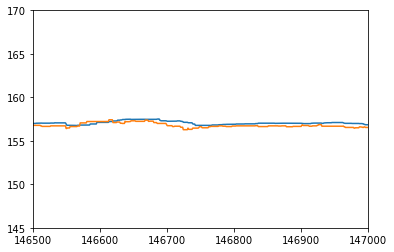

In [38]:
y_data_borpi = list(zip(*test_data))
print(preds[0])
items_plot = [y_data_borpi[1][t] for t in range(len(y_data_borpi[1]))]
plt.plot(list(range(len(preds))), preds)
plt.plot(list(range(len(items_plot))), items_plot)
axes = plt.gca()
axes.set_ylim([145,170])
axes.set_xlim([146500,147000])
plt.show()